In [1]:
import sys
import numpy as np

sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/hdphmmwl/testing', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [67]:
import random
# Load state sequence and data from the pickle file
import pickle
with open('/Users/david/Documents/mastersCode/ubm/final/tests/train-test-val.pkl', 'rb') as file:
    sample_holder = pickle.load(file)

In [88]:
train = sample_holder['train']
val = sample_holder['val']

In [103]:
from final import useful
def get_feature(samp):
    # add optionals here if needed
    # mfcc
    # feat = librosa.feature.mfcc(y=samp,sr=4000,n_mfcc=13).T
    feat = useful.get_log_power_feature(samp, nfft=128)
    return feat

In [222]:
train.features = []
for sample in train.samples:
    train.features.append(get_feature(sample))

val.features = []
for sample in val.samples:
    val.features.append(get_feature(sample))

In [223]:

feat_indicis = train.sample_labels == 0 # humpback
hmm_features = [item for item, condition in zip(train.features, feat_indicis) if condition]

feat_indicis_val = val.sample_labels == 0 # humpback
hmm_features_val = [item for item, condition in zip(val.features, feat_indicis_val) if condition]
# cur_hmm.fit(np.concatenate(hmm_features))

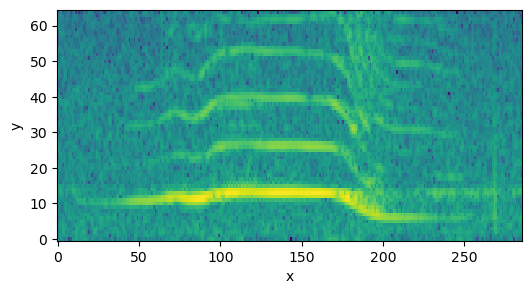

In [224]:
from final.useful import vis_helper
vis_helper(hmm_features_val[0])

In [267]:
# # get_log_power_feature()
# labels = np.array(sample_holder.sample_labels)
# samples = sample_holder.samples
# features = sample_holder.features
# from sklearn.utils import check_random_state
# rs = check_random_state(546)
# label = 1
# indices = np.array(labels == label)
# selected_features = [feats for feats, select in zip(features, indices) if select]
# lens = []
#
# for feat in selected_features[:5]:
#     lens.append(len(feat))
# lens = np.array(lens)
#
concatenated_list = [
    np.concatenate(random.sample(hmm_features, 3))
    for _ in range(10)
]

In [268]:
import final.models.hdphmm.hdphmmwl.hdphmmwl as hdphmm
from final.models.hdphmm.helpers.plot_hmm import plot_hmm_data
import final.models.hdphmm.hdphmmwl.consts as const
import final.models.hdphmm.hdphmmwl.numba_wl as numba
from importlib import reload
reload(const)
reload(numba)
reload(hdphmm)

sbp = {
    const.ALPHA0: 0.1,
    const.GAMMA0: 0.01,
    const.KAPPA0: 0.5,
}
sbp[const.RHO0] = sbp[const.KAPPA0] / ( sbp[const.KAPPA0] + sbp[const.ALPHA0])
temp = 1
hdp_hmm = hdphmm.HDPHMMWL(concatenated_list, 19, iterations=20, sbp=sbp, feature_a=11, feature_b=12)

# hdp_hmm.gamma0 = 0.01
# hdp_hmm.nu0 = 200
# hdp_hmm.V0 = np.eye(hdp_hmm.D) * 10

sbp given


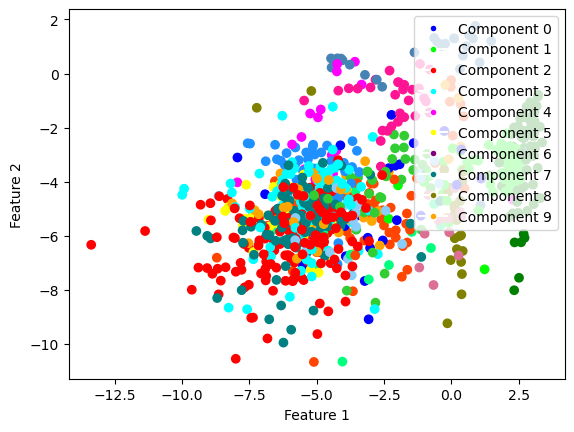

In [269]:
import final.models.hdphmm.helpers.plot_hmm as plot_hmm
reload(plot_hmm)
hdp_hmm.create_hmm()
hdp_hmm.plot_hmmlearn(15,16,20)

In [270]:
hdp_hmm.fit_multiple(verbose=True, outer_its=1, iterations=20)

# plt.plot(range(0,len(hdp_hmm.trace[const.TIME])), hdp_hmm.trace[const.TIME], marker="None")
# plt.xlabel('iteration')
# plt.ylabel('ARI')
# plt.xlim(0,1)
# #plt.savefig("./image/ari.png")
# plt.show()
# plt.close()
print('average time for one gibbs sweep: ', np.mean(hdp_hmm.trace[const.TIME]))

it:  0  || Likelihood:  -22831.39983110772  || n_components:  19
it:  10  || Likelihood:  -22540.56061562483  || n_components:  19
completed gibbs sampling in  3.7769927978515625
it:  0  || Likelihood:  -23161.258931951954  || n_components:  13
it:  10  || Likelihood:  -23135.062134928372  || n_components:  13
completed gibbs sampling in  2.7421958446502686
it:  0  || Likelihood:  -24502.247130056683  || n_components:  12
it:  10  || Likelihood:  -24046.13735610399  || n_components:  12
completed gibbs sampling in  2.5440239906311035
it:  0  || Likelihood:  -23583.759192266098  || n_components:  17
it:  10  || Likelihood:  -23541.349161627262  || n_components:  17
completed gibbs sampling in  3.277392864227295
it:  0  || Likelihood:  -24808.66992660573  || n_components:  12
it:  10  || Likelihood:  -24463.52401797267  || n_components:  11
completed gibbs sampling in  2.491253137588501
it:  0  || Likelihood:  -23066.14504643099  || n_components:  12
it:  10  || Likelihood:  -23234.13940

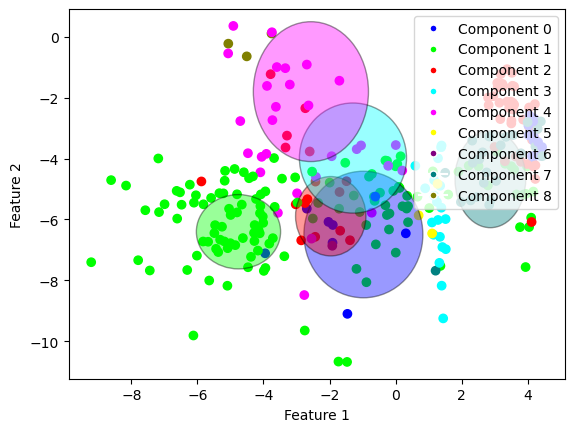

In [250]:
plot_hmm.plot_hmm_learn(concatenated_list[0], hdp_hmm.hmm, 5, 14, 16)

In [271]:
from hmmlearn.hmm import GaussianHMM
hdp_hmm.create_hmm()
gibbs_hmm = hdp_hmm.hmm
hdp_hmm.create_hmm()

In [272]:
gibbs_hmm.fit(np.concatenate(hmm_features))

GaussianHMM(init_params='', n_components=11)

In [273]:
test_hmm = GaussianHMM(11, covariance_type='diag')
test_hmm.fit(np.concatenate(hmm_features))

GaussianHMM(n_components=11)

In [274]:
print('hmm          ', test_hmm.score(hmm_features[0]))
print('hdp_hmm      ', hdp_hmm.hmm.score(hmm_features[0]))
print('hdp_hmm reg: ', gibbs_hmm.score(hmm_features[0]))

hmm           -36855.76502808796
hdp_hmm       -38903.74800163049
hdp_hmm reg:  -36661.601470971


In [275]:
for i in range(len(hmm_features_val)):
    print('hmm          ', test_hmm.score(hmm_features_val[i]))
    print('hdp_hmm      ', hdp_hmm.hmm.score(hmm_features_val[i]))
    print('reg hdp hmm  ', gibbs_hmm.score(hmm_features_val[i]))
    print('')

hmm           -36110.989800628195
hdp_hmm       -36219.3951931301
reg hdp hmm   -36005.91504172426

hmm           -35519.70436222621
hdp_hmm       -38714.15854024107
reg hdp hmm   -36002.36131038648

hmm           -40540.095957019046
hdp_hmm       -44943.71812771321
reg hdp hmm   -40947.0645622166

hmm           -39569.86319579867
hdp_hmm       -41649.002714049784
reg hdp hmm   -39409.50292222456

hmm           -41403.01667175637
hdp_hmm       -47660.69921136395
reg hdp hmm   -41932.304200463666



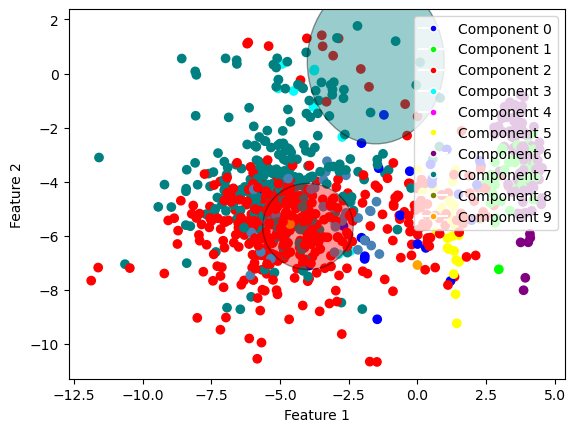

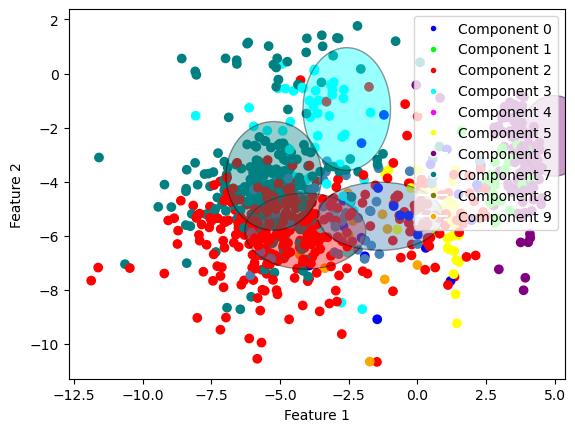

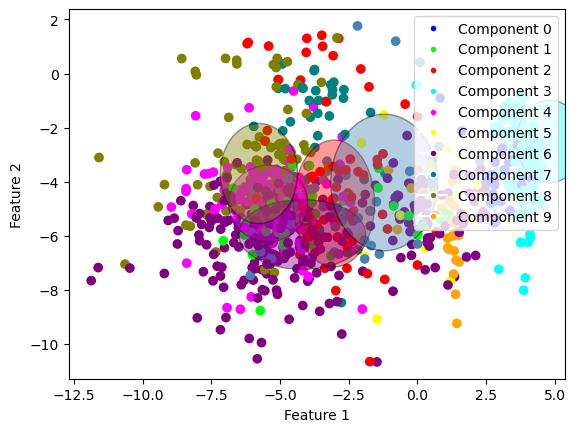

In [276]:
plot_hmm.plot_hmm_learn(concatenated_list[0], hdp_hmm.hmm, 5, 14, 16)
plot_hmm.plot_hmm_learn(concatenated_list[0], gibbs_hmm, 5, 14, 16)
plot_hmm.plot_hmm_learn(concatenated_list[0], test_hmm, 5, 14, 16)

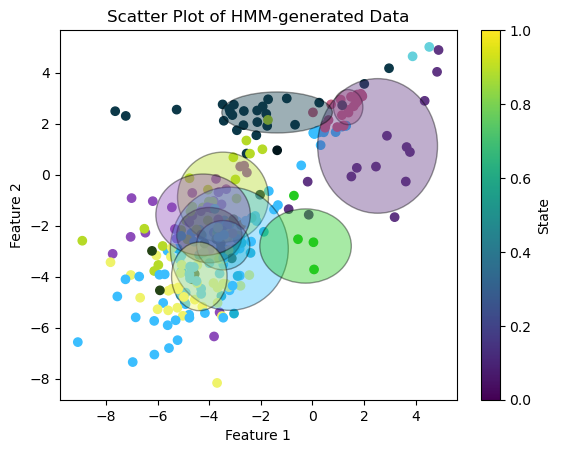

In [105]:
plot_hmm.plot_hmm_data(aic_states_humpback[3], hdp_hmm.Z, hdp_hmm.K, hdp_hmm.mu, hdp_hmm.sigma, counts=hdp_hmm.nk, percent=1,feature_a=11, feature_b=12)

In [46]:
gibbs_hmm = hdp_hmm.hmm
em_hmm = GaussianHMM(10, covariance_type='diag')
em_hmm.fit(smaller_features)
ll_gibbs, _ = gibbs_hmm.decode(smaller_features)
ll_em, ss_em = em_hmm.decode(smaller_features)
print('gibbs: ', ll_gibbs, 'em: ', ll_em)

gibbs:  -26370.479803144364 em:  -26718.644665980133


In [47]:
gibbs_hmm.fit(smaller_features)

GaussianHMM(init_params='', n_components=18)

In [48]:
ll_gibbs, _ = gibbs_hmm.decode(smaller_features)
ll_em, ss_em = em_hmm.decode(smaller_features)
print('gibbs: ', ll_gibbs, 'em: ', ll_em)

gibbs:  -24635.587943985214 em:  -26718.644665980133


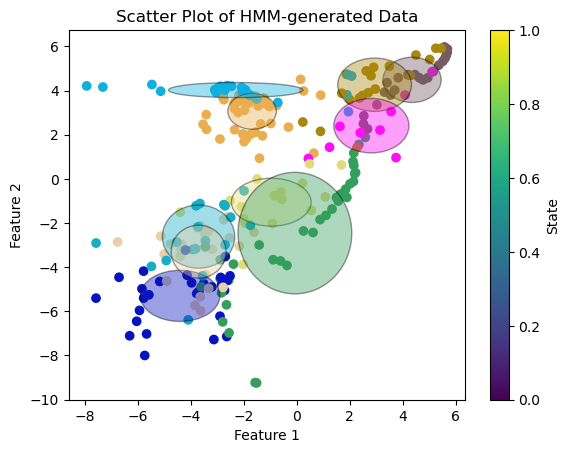

In [49]:
import final.models.hdphmm.helpers.plot_hmm as plot_hmm
reload(plot_hmm)
plot_hmm.plot_hmm_data(smaller_features, ss_em, em_hmm.n_components, em_hmm.means_, em_hmm.covars_, feature_a=11, feature_b=12)